In [2]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal,norm, expon, poisson, gamma, binom
import matplotlib.pyplot as plt


## Ex1 ##

### (i) ###

In [3]:
a_values = [1, 3, 10]  # Values of a to test
d = 2  # Dimension
C = np.array([[4, -1], [-1, 4]])  # Covariance matrix
N = 10**5  # Number of samples

In [4]:
def cmc_simulation(a, N, C):
    """
    Compute simulation estimates of z = P(X in A) using Crude Monte Carlo (CMC).
    Returns the estimate and the 95% confidence interval.
    """
    # Generate N samples from N(0, C)
    mean = np.zeros(2)  # Mean vector [0, 0]
    samples = np.random.multivariate_normal(mean, C, N)
    
    # Define region A: x >= a and y >= a
    A = (samples[:, 0] >= a) & (samples[:, 1] >= a)
    
    # Estimate probability
    z_hat = np.mean(A)
    
    # Standard error
    std_error = np.std(A) / np.sqrt(N)
    
    # 95% confidence interval
    ci = [z_hat - 1.96 * std_error, z_hat + 1.96 * std_error]
    return z_hat, ci

In [5]:
cmc_results = []
for a in a_values:
    z_hat, ci = cmc_simulation(a, N, C)
    cmc_results.append((a, z_hat, ci))

In [6]:
columns_cmc = ["a", "CMC Estimate", "95% Confidence Interval"]
df_cmc = pd.DataFrame(cmc_results, columns=columns_cmc)
print(df_cmc)

    a  CMC Estimate                         95% Confidence Interval
0   1       0.06563      [0.06409514725061666, 0.06716485274938333]
1   3       0.00140  [0.0011682520665895811, 0.0016317479334104189]
2  10       0.00000                                      [0.0, 0.0]


In [7]:
### (ii) ###

In [8]:
def importance_sampling_simulation_with_likelihood(a, N, C):
    """
    Perform importance sampling to estimate z = P(X in A) using the provided likelihood computation method.
    Returns the estimate and the 95% confidence interval.
    """
    # Define the maximizer b = x* = (a, a)
    b = np.array([a, a])
    
    # Generate N samples from N(b, C)
    samples = np.random.multivariate_normal(b, C, N)
    
    # Compute the likelihood ratio L
    C_inv = np.linalg.inv(C)  
    x_star_C_inv_X = np.dot(samples, np.dot(C_inv, b))
    x_star_C_inv_x_star = np.dot(b, np.dot(C_inv, b))
    likelihood_ratios = np.exp(-x_star_C_inv_X + 0.5 * x_star_C_inv_x_star)
    
    # Define region A
    A = (samples[:, 0] >= a) & (samples[:, 1] >= a)
    
    # Estimate probability
    z_hat = np.mean(likelihood_ratios * A)
    
    # Standard error
    std_error = np.std(likelihood_ratios * A) / np.sqrt(N)
    
    # 95% confidence interval
    ci = [z_hat - 1.96 * std_error, z_hat + 1.96 * std_error]
    return z_hat, ci

In [9]:
results_with_likelihood = []
for a in a_values:
    z_hat, ci = importance_sampling_simulation_with_likelihood(a, N, C)
    results_with_likelihood.append((a, z_hat, ci))

In [10]:
columns_likelihood = ["a", "IS Estimate", "95% Confidence Interval"]
df_is_likelihood = pd.DataFrame(results_with_likelihood, columns=columns_likelihood)
print(df_is_likelihood)

    a   IS Estimate                          95% Confidence Interval
0   1  6.520622e-02       [0.06433284125432424, 0.06607960291374611]
1   3  1.355657e-03   [0.0013280063149461458, 0.0013833077502935461]
2  10  1.163291e-17  [1.1027264867959808e-17, 1.223856144247953e-17]


### (iii) ###

In [11]:
def importance_sampling_with_scaled_covariance(a, N, C, delta):
    """
    Perform importance sampling with scaled covariance matrix delta * C.
    Returns the estimate and the 95% confidence interval.
    """
    # Define the maximizer b = x* = (a, a)
    b = np.array([a, a])
    
    # Scale the covariance matrix
    scaled_C = delta * C
    
    # Generate N samples from N(b, delta * C)
    samples = np.random.multivariate_normal(b, scaled_C, N)
    
    # Compute the likelihood ratio L
    scaled_C_inv = np.linalg.inv(scaled_C)  # Inverse of scaled covariance matrix
    C_inv = np.linalg.inv(C)  # Inverse of original covariance matrix
    
    # Log-likelihood ratio computation
    x_star_C_inv_X = np.dot(samples, np.dot(C_inv, b))
    x_star_C_inv_x_star = np.dot(b, np.dot(C_inv, b))
    likelihood_ratios = np.exp(-x_star_C_inv_X + 0.5 * x_star_C_inv_x_star)
    
    # Adjust for scaling of the proposal distribution
    f_scaled = multivariate_normal.pdf(samples, mean=b, cov=scaled_C)
    f_original = multivariate_normal.pdf(samples, mean=np.zeros(d), cov=C)
    likelihood_ratios = f_original / f_scaled
    
    # Define region A: x >= a and y >= a
    A = (samples[:, 0] >= a) & (samples[:, 1] >= a)
    
    # Estimate probability
    z_hat = np.mean(likelihood_ratios * A)
    
    # Standard error
    std_error = np.std(likelihood_ratios * A) / np.sqrt(N)
    
    # 95% confidence interval
    ci = [z_hat - 1.96 * std_error, z_hat + 1.96 * std_error]
    return z_hat, ci




In [12]:
# Experiment with different delta values
delta_values = [0.5, 1, 2,5]
scaled_results = []

for delta in delta_values:
    for a in a_values:
        z_hat, ci = importance_sampling_with_scaled_covariance(a, N, C, delta)
        scaled_results.append((a, delta, z_hat, ci, ci[1]-ci[0]))

# Display results
columns_scaled = ["a", "delta", "IS Estimate", "95% Confidence Interval", "Interval Width"]
df_scaled = pd.DataFrame(scaled_results, columns=columns_scaled)
print(df_scaled)

     a  delta   IS Estimate                           95% Confidence Interval  \
0    1    0.5  6.476875e-02         [0.0639170872642984, 0.06562041554219211]   
1    3    0.5  1.378194e-03     [0.0013577532929278755, 0.001398634968681715]   
2   10    0.5  1.182287e-17  [1.1379302542762432e-17, 1.2266440622905325e-17]   
3    1    1.0  6.576068e-02        [0.06488340327081102, 0.06663796210806039]   
4    3    1.0  1.376139e-03    [0.0013480730574387412, 0.0014042053835917946]   
5   10    1.0  1.133656e-17  [1.0724534103059909e-17, 1.1948581979755896e-17]   
6    1    2.0  6.447719e-02            [0.06330525490297, 0.0656491166770423]   
7    3    2.0  1.380821e-03    [0.0013409855313883362, 0.0014206565132629837]   
8   10    2.0  1.116620e-17  [1.0312940926071446e-17, 1.2019452809432188e-17]   
9    1    5.0  6.351564e-02       [0.061708247612789834, 0.06532302807508909]   
10   3    5.0  1.396541e-03    [0.0013337605368687986, 0.0014593220571585987]   
11  10    5.0  1.263948e-17 

## Ex2 ##

### We fix the tilting parameter to 0.5 to verify one-dimensinal distributions 

### (i) exponential distibution

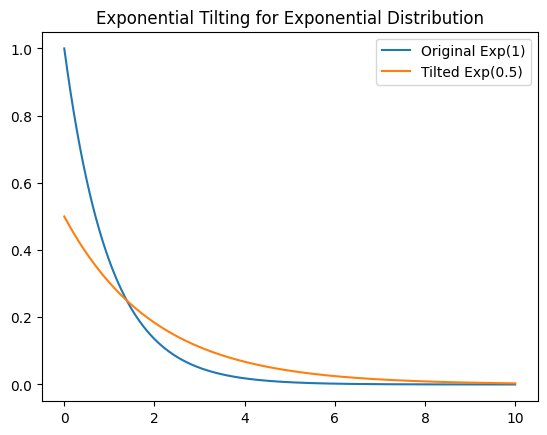

Original Mean: 0.9950885919436425
Theoretical Mean: 2.0
Tilted Mean: 2.0135896071932935


In [21]:

lambd = 1  # Original rate parameter
theta = 0.5  # Tilting parameter

theoretical_mean_tilted = 1 / (lambd - theta)

# Original distribution
X = np.random.exponential(1 / lambd, 10000)

# Tilted distribution
lambda_theta = lambd - theta
if lambda_theta <= 0:
    raise ValueError("Invalid tilting parameter: lambda_theta must be > 0.")
X_tilted = np.random.exponential(1 / lambda_theta, 10000)

# Plot the distributions
x = np.linspace(0, 10, 1000)
plt.plot(x, expon.pdf(x, scale=1 / lambd), label=f"Original Exp({lambd})")
plt.plot(x, expon.pdf(x, scale=1 / lambda_theta), label=f"Tilted Exp({lambda_theta})")
plt.legend()
plt.title("Exponential Tilting for Exponential Distribution")
plt.show()

# Verify means
print("Original Mean:", np.mean(X))
print("Theoretical Mean:",theoretical_mean_tilted)
print("Tilted Mean:", np.mean(X_tilted))


### (i')Gamma Distribution ###

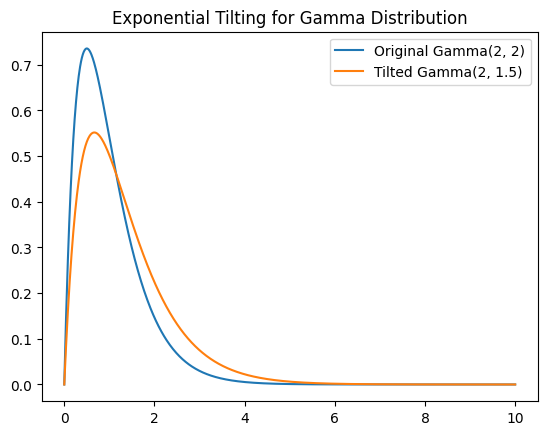

Original Mean: 1.0039914011323676
Theoretical Mean: 1.3333333333333333
Tilted Mean: 1.3424399291066138


In [20]:

alpha, lambd = 2, 2  # Shape and rate parameters of original Gamma distribution
theta = 0.5  # Tilting parameter

# Original distribution
X = np.random.gamma(alpha, 1 / lambd, 10000)

# Tilted distribution
lambda_theta = lambd - theta
if lambda_theta <= 0:
    raise ValueError("Invalid tilting parameter: lambda_theta must be > 0.")
X_tilted = np.random.gamma(alpha, 1 / lambda_theta, 10000)
theoretical_mean_tilted = alpha / lambda_theta
# Plot the distributions
x = np.linspace(0, 10, 1000)
plt.plot(x, gamma.pdf(x, alpha, scale=1 / lambd), label=f"Original Gamma({alpha}, {lambd})")
plt.plot(x, gamma.pdf(x, alpha, scale=1 / lambda_theta), label=f"Tilted Gamma({alpha}, {lambda_theta})")
plt.legend()
plt.title("Exponential Tilting for Gamma Distribution")
plt.show()

# Verify means
print("Original Mean:", np.mean(X))
print("Theoretical Mean:" ,theoretical_mean_tilted)
print("Tilted Mean:", np.mean(X_tilted))


### (ii)Binomial distribution

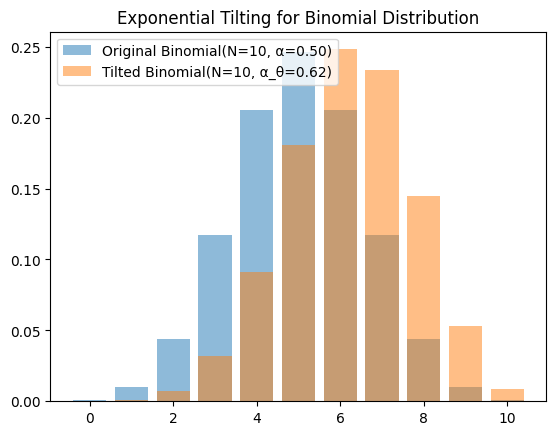

Original Mean: 4.9871
Theoretical Mean: 6.224593312018546
Tilted Mean: 6.258


In [23]:
N = 10  # Number of trials
alpha = 0.5  # Original probability of success
theta = 0.5  # Tilting parameter

# Compute tilted probability of success
alpha_theta = alpha * np.exp(theta) / (1 - alpha + alpha * np.exp(theta))
theoretical_mean_tilted = N * alpha_theta
# Generate samples
# Original distribution
X = np.random.binomial(N, alpha, 10000)
# Tilted distribution
X_tilted = np.random.binomial(N, alpha_theta, 10000)

# Plot the distributions
x = np.arange(0, N + 1)
plt.bar(x, binom.pmf(x, N, alpha), alpha=0.5, label=f"Original Binomial(N={N}, α={alpha:.2f})")
plt.bar(x, binom.pmf(x, N, alpha_theta), alpha=0.5, label=f"Tilted Binomial(N={N}, α_θ={alpha_theta:.2f})")
plt.legend()
plt.title("Exponential Tilting for Binomial Distribution")
plt.show()

# Verify means
print("Original Mean:", np.mean(X))
print("Theoretical Mean:", theoretical_mean_tilted)
print("Tilted Mean:", np.mean(X_tilted))

### (iii) Poisson distribution

In [24]:
# Parameters for Poisson Distribution
mu = 3  # Original mean
theta = 0.5  # Tilting parameter

# Compute tilted mean
mu_theta = mu * np.exp(theta)

theoretical_mean_tilted = mu_theta

# Generate samples
X_original = np.random.poisson(mu, 10000)  # Original Poisson samples
X_tilted = np.random.poisson(mu_theta, 10000)  # Tilted Poisson samples

# Empirical means
empirical_mean_original = np.mean(X_original)
empirical_mean_tilted = np.mean(X_tilted)

print("Original Mean:", np.mean(X_original))
print("Tilted Mean:", np.mean(X_tilted))
print("Theoretical Mean (Tilted):", theoretical_mean_tilted)



Original Mean: 2.988
Tilted Mean: 4.9165
Theoretical Mean (Tilted): 4.946163812100385


### (iv) Normal distribution

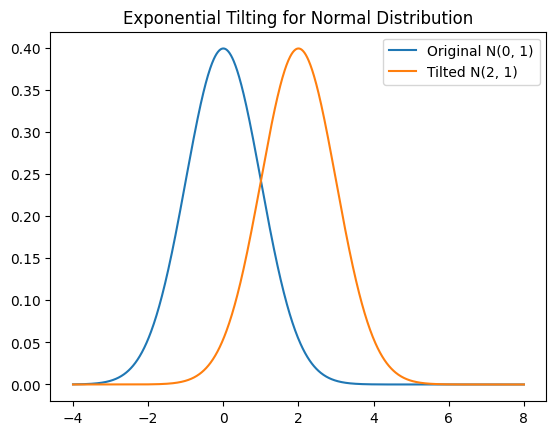

Original Mean: -0.006612957690286785
Tilted Mean: 2.0074327302282056
Theoretical Mean (Tilted): 2


In [25]:

mu, sigma = 0, 1  # Original mean and standard deviation
theta = 2         # Tilting parameter

# Original distribution
X = np.random.normal(mu, sigma, 10000)

# Tilted distribution
mu_theta = mu + theta * sigma**2  # Tilted mean
theoretical_mean_tilted = mu_theta
X_tilted = np.random.normal(mu_theta, sigma, 10000)

# Plot the distributions
x = np.linspace(-4, 8, 1000)
plt.plot(x, norm.pdf(x, mu, sigma), label="Original N(0, 1)")
plt.plot(x, norm.pdf(x, mu_theta, sigma), label=f"Tilted N({mu_theta}, 1)")
plt.legend()
plt.title("Exponential Tilting for Normal Distribution")
plt.show()

# Verify means
print("Original Mean:", np.mean(X))
print("Tilted Mean:", np.mean(X_tilted))
print("Theoretical Mean (Tilted):", theoretical_mean_tilted)

### (v) Standard multivariate

In [27]:
mu = np.array([0, 0])  # Original mean vector
C = np.array([[1, 0.5], [0.5, 1]])  # Original covariance matrix
theta = np.array([0.5, -0.5])  # Tilting parameter

# Compute tilted mean
mu_theta = mu + np.dot(C, theta)

theoretical_mean_tilted = mu_theta

# Generate samples
X_original = np.random.multivariate_normal(mu, C, 10000)  # Original Multivariate Normal samples
X_tilted = np.random.multivariate_normal(mu_theta, C, 10000)  # Tilted Multivariate Normal samples

# Empirical means
empirical_mean_original = np.mean(X_original, axis=0)
empirical_mean_tilted = np.mean(X_tilted, axis=0)

print("Original Mean:", empirical_mean_original)
print("Tilted Mean:", empirical_mean_tilted)
print("Theoretical Mean (Tilted):", theoretical_mean_tilted)


Original Mean: [ 0.00101185 -0.01385513]
Tilted Mean: [ 0.2503054  -0.24404129]
Theoretical Mean (Tilted): [ 0.25 -0.25]
